<img src="../images/ipcc.jpg" width=800 alt="IPCC"></img>

# Cambio Climático: Ensambles multimodelo

---

## Introducción
En este cuadernillo (Notebook) aprenderemos:

1. Breve introduccion a los escenarios de Cambio Climático
1. Proyecto de inter-comparación de modelos de clima acoplados - CMIP
1. Acceso a los datos CMIP6 en formato Zarr
1. Reproduccion de la gráfica de la Temperatura Media Global de la Superficie del Mar - CMIP6

## Prerequisitos

| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necesario |  Manejo de datos multidimensionales espacializados|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necesario |  Generación de gráficas|
| [CMIP6](https://projectpythia.org/cmip6-cookbook/README.html#) | Necesario |  Ejemplos y analisis de CMIP6|
| [NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Útil | Familiaridad con la estructura de datos y metadatos. |
| [Intake](https://projectpythia.org/intake-cookbook/README.html) | Útil | Cátalogo que nos permite acceder a datos de diversas fuentes |


- **Tiempo de aprendizaje**: 30 minutos.

---

## Librerias

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xmip.utils import google_cmip_col
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import match_metrics
from xmip.postprocessing import concat_members
from datatree import DataTree
from xarrayutils.plotting import shaded_line_plot
from pandas import date_range
xr.set_options(keep_attrs=True)
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)

## 1. Introduccion a los escenarios de Cambio Climático

Los escenarios de cambio climático son una serie de modelos que se han desarrollado con el fin de comprender nuestro clima y las implicaciones futuras de las continuas emiciones de gases de efecto invernadero en la atmósfera. Estos esfuerzos se han concentrado en el proyecto de intercomparacion de modelos (MIP) que invita a entidades de diferentes partes del mundo a realizar simulaciones utilizando modelos bajo escenarios de forzamiento radiativo centralizado (Abernathey, R. 2021). El más reciente Proyecto de Intercomparación de Modelos Acoplados fase 6 ([CMIP6](https://gmd.copernicus.org/articles/9/1937/2016/)) representa un esfuerzo internacional para enfocar e el conocimiento acerca de la posible evolucion del sistema climático futuro, y qye se encuentra consignado y resumido en el [Informe del Panel Intergubernamental sobre el Cambio Climático](https://github.com/IPCC-WG1/Chapter-9).

A continuación podemos ver una presentación corta que nos permite entender un poco más que hay detras del Cambio Climático y la modelación climática cortesía de [Climate Match Academy](https://comptools.climatematch.io/tutorials/intro.html)

In [2]:
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "y2bdn"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

print("Cortesia: Climate Match Academy (CC BY 4.0)")

Output()

Cortesia: Climate Match Academy (CC BY 4.0)


## 2. Acceso a los datos CMIP6

Los datos de los diferentes modelos se encuentran disponibles en la plataforma en la nube de `Google Storage` en formato [`Zarr`](https://zarr.readthedocs.io/en/stable/). Para acceder a los datos de los diferentes escenarios de cambio climático podemos usar la libreria [`xmip`](https://cmip6-preprocessing.readthedocs.io/en/latest/?badge=latest). Para crear una conexión con el repositorio de datos de Google usaremos el método [`google_cmip_col`](https://cmip6-preprocessing.readthedocs.io/en/latest/_modules/xmip/utils.html#google_cmip_col:~:text=def%20google_cmip_col(catalog%3D%22main%22)%3A) que nos permite acceder a los datos de [`Pangeo`](https://pangeo.io/) a través de [`intake`](https://intake.readthedocs.io/en/latest/) de la siguiente manera 

In [3]:
cat = google_cmip_col()
cat

Como podemos ver hay una gran cantidad de modelaciones de más de 30 instituciones alrededor del mundo. Para efectos pedagógicos, vamos a hacer una consulta de los modelos [IPSL](https://cmc.ipsl.fr/ipsl-climate-models/), [MPI](https://gmd.copernicus.org/articles/12/3241/2019/), [GFDL](https://www.gfdl.noaa.gov/research_highlight/the-gfdl-earth-system-model-version-4-1-gfdl-esm4-1-model-description-and-simulation-characteristics/), [EC](https://ec-earth.org/), [CMCC](https://www.cmcc.it/models/cmcc-esm-earth-system-model) y [CESM2](https://www.cesm.ucar.edu/models/cesm2) para el periodo **histórico** y cada uno de los de los **escenarios (SSP - Shared Socioeconomic Pathways) proyectados** (`ssp126`, `ssp245`, `ssp370`, `ssp585`). 

Debemos crear un diccionario que nos permita posteriormente filtrar los datos deseados de la siguiente manera

In [4]:
query = dict(
    source_id = [
     'IPSL-CM6A-LR',
     'MPI-ESM1-2-LR',
     'GFDL-ESM4',
     'EC-Earth3',
     'CMCC-ESM2',
     'CESM2',
    ],
    experiment_id = ['historical','ssp126', 'ssp370', 'ssp245', 'ssp585'],
    grid_label='gn',
)

El parámetro de etiqueta de reticula [`grid_label`](https://github.com/WCRP-CMIP/CMIP6_CVs/blob/master/CMIP6_grid_label.json) hace referencia a si los datos son reportados en retícula original (`gn`) o fue reprocesado a una nueva retícula (`gr`) en formato `lat` y `lon`.

Para filtar los datos podemos aplicar el método `.search` a nuestro catálogo. Le pasamos los filtros previamente definidos incluyendo el identificador de la [variable](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271) (`variable_id`), para nuestro caso la temperatura superficial del mar `tos`. Pasamos también el identificador de miembro `member_id` que para nuestro caso es `r1i1p1f1`.  

La etiqueta de miembro nos indica lo siguiente:
*  r = realización
*  i = inicialización
*  p = física (parametrización)
*  f = forzamiento radiativo

 Como último parámetro en nuestro ejemplo pasamos el identificador de table `table_id` que para nuestro caso son datos mensuales del oceano `Omon`.

In [5]:
cat_filt = cat.search(
    **query,
    variable_id='tos',
    member_id=['r1i1p1f1',],#'r2i1p1f1'
    table_id='Omon'
)
cat_filt

`Intake` nos permite acceder a los datos de marea rápida y fácil usando `Xarray`. Para cargar estos datos en un `Dataset` podemos aplicarle el método `.to_dataset_dict` que nos permite crear un `diccionario` con todos los modelos. Podemos pasar un diccionario `kwargs` con argumentos que nos permiten realizar preprocesamiento de los datos como renombrar algunos archivos, corregir coordenadas, unidades, entre otros, como podemos ver [acá](https://github.com/jbusecke/xMIP/blob/ec4006a7335ca00fd988cf03ac7121f046610f8a/xmip/preprocessing.py#L445). 

In [6]:
kwargs = dict(preprocess=combined_preprocessing, xarray_open_kwargs=dict(use_cftime=True), aggregate=False)
ddict = cat_filt.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [7]:
print(list(ddict.keys())[:2])

['ScenarioMIP.CMCC.CMCC-ESM2.ssp126.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp126/r1i1p1f1/Omon/tos/gn/v20210126/.20210126', 'ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3/ssp585/r1i1p1f1/Omon/tos/gn/v20200918/.20200918']


Revisemos el contenido de uno de estos archivos

In [8]:
ds_test = ddict['ScenarioMIP.CMCC.CMCC-ESM2.ssp126.r1i1p1f1.Omon.tos.gn.gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp126/r1i1p1f1/Omon/tos/gn/v20210126/.20210126']
display(ds_test)

<xarray.Dataset>
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, x: 292,
                     y: 362, vertex: 4, bnds: 2)
Coordinates:
    lat             (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
    lon             (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
  * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    lat_verticies   (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
    lon_verticies   (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
    time_bounds     (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 285 286 287 288 289 290 291
  * y               (y) int64 0 1 2 3 4 5 6 7 ... 355 356 357 358 359 360 361
    lon_bounds      (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
    lat_bounds      (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
Dimensions without coordinates: vertex, bnds
Data variables:
    tos             (member_id, dcpp_init_year, time, x, y) float32 dask.array<chunksize=(1, 1, 253, 292, 362), meta=np.ndarray>
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      ScenarioMIP
    branch_method:                    standard
    branch_time_in_child:             60225.0
    branch_time_in_parent:            60225.0
    cmor_version:                     3.6.0
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-...
    intake_esm_attrs:version:         20210126
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           ScenarioMIP.CMCC.CMCC-ESM2.ssp126.r1i1p...

Ahora una inspeccion gráfica

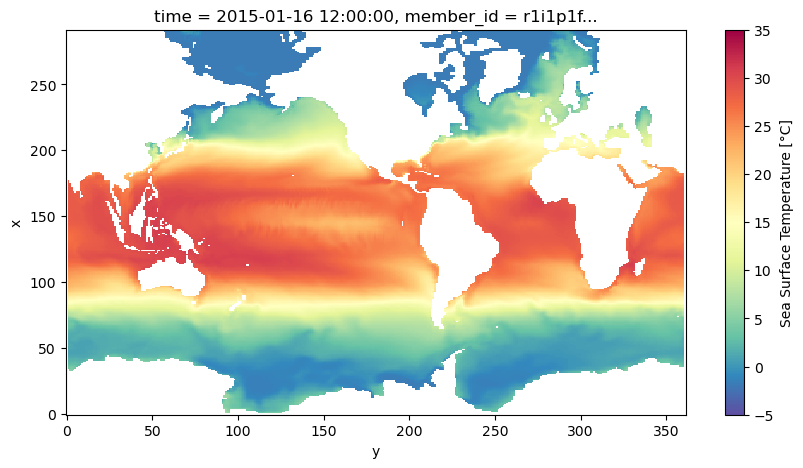

In [9]:
ds_test.isel(member_id=0, dcpp_init_year=0,time=0).tos.plot(cmap='Spectral_r', vmin=-5, vmax=35)

## 2. Temperatura media global ponderada

La temperatura superficial del mar, y cualquier otra variable o salida de los modelos de cambio climático, debe ser ponderada por el **area** de cada celda. 

<img src="../images/cubed_sphere.jpeg" width=400 alt="IPCC"></img>

Creditos: [Gael Forget](https://gaelforget.net/). Para mas información acerca de las simulaciones y las reticulas ver [https://doi.org/10.5194/gmd-8-3071-2015](https://gmd.copernicus.org/articles/8/3071/2015/)

Estas áreas ya estan calculadas y disponibles para su consulta de manera similar a los datos de `temperatura`. Hagamos una consulta al catálogo similar a la anterior cambiando los campos de `variable_id=areacello` y `table_id=Ofx`. 

In [10]:
cat_area = cat.search(
    **query,
    table_id='Ofx',
    variable_id='areacello',
)
ddict_area = cat_area.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


para realizar el cálculo de la temperatura media ponderada por latitud podemos utilizar el módulo [`match_metrics`](https://cmip6-preprocessing.readthedocs.io/en/latest/_modules/xmip/postprocessing.html) de la libreria `xmip` de python de la siguiente manera

In [11]:
ddict_w_area = match_metrics(ddict, ddict_area, 'areacello', print_statistics=True) 

Processed 26 datasets.
Exact matches:{'areacello': 0}
Other matches:{'areacello': 26}
No match found:{'areacello': 0}


In [12]:
#ddict_w_area

Ahora procederemos a concatenar los miembros en cada uno de los modelos usando el módulo [`.concat_members`](https://cmip6-preprocessing.readthedocs.io/en/latest/_modules/xmip/postprocessing.html#concat_members)

In [13]:
ddict_trimmed = {k:ds.sel(time=slice(None, '2100')) for k,ds in ddict_w_area.items()}
ddict_combined_members = concat_members(
    ddict_w_area,
    concat_kwargs = {'coords':'minimal', 'compat':'override', 'join':'override'}
)

`Xarray.Dataset` no soporta tener multiples `Datasets`  anidados en un solo objeto de `Xarray`. Sin embargo podemos crear un objeto llamado [`Xarray.datatree`](https://xarray-datatree.readthedocs.io/en/latest/quick-overview.html) que nos permite poner todos nuestros `Datasets` en un solo objeto de manerar herarquica. Para entender un poco mas los formatos y objeto de tipo herarquico vea este [ejemplo](https://xarray-datatree.readthedocs.io/en/latest/hierarchical-data.html)

In [14]:
# create a path: dataset dictionary, where the path is based on each datasets attributes
tree_dict = {f"{ds.source_id}/{ds.experiment_id}/":ds for ds in ddict_combined_members.values()}

dt = DataTree.from_dict(tree_dict)
display(dt)

DataTree('None', parent=None)
├── DataTree('CMCC-ESM2')
│   ├── DataTree('ssp126')
│   │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, x: 292,
│   │                            y: 362, vertex: 4, bnds: 2)
│   │       Coordinates: (12/13)
│   │           lat             (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
│   │           lon             (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │           lat_verticies   (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
│   │           lon_verticies   (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
│   │           time_bounds     (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
│   │           ...              ...
│   │         * y               (y) int64 0 1 2 3 4 5 6 7 ... 355 356 357 358 359 360 361
│   │           lon_bounds      (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
│   │           lat_bounds      (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │           areacello       (member_id, dcpp_init_year, x, y) float32 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │       Dimensions without coordinates: vertex, bnds
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time, x, y) float32 dask.array<chunksize=(1, 1, 253, 292, 362), meta=np.ndarray>
│   │       Attributes: (12/64)
│   │           Conventions:                      CF-1.7 CMIP-6.2
│   │           activity_id:                      ScenarioMIP
│   │           branch_method:                    standard
│   │           branch_time_in_child:             60225.0
│   │           branch_time_in_parent:            60225.0
│   │           cmor_version:                     3.6.0
│   │           ...                               ...
│   │           intake_esm_attrs:variable_id:     tos
│   │           intake_esm_attrs:grid_label:      gn
│   │           intake_esm_attrs:zstore:          gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-...
│   │           intake_esm_attrs:version:         20210126
│   │           intake_esm_attrs:_data_format_:   zarr
│   │           intake_esm_dataset_key:           ScenarioMIP.CMCC.CMCC-ESM2.ssp126.r1i1p...
│   ├── DataTree('historical')
│   │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, x: 292,
│   │                            y: 362, vertex: 4, bnds: 2)
│   │       Coordinates: (12/13)
│   │           lat             (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
│   │           lon             (x, y) float64 dask.array<chunksize=(292, 362), meta=np.ndarray>
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │           lat_verticies   (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
│   │           lon_verticies   (x, y, vertex) float64 dask.array<chunksize=(292, 362, 4), meta=np.ndarray>
│   │           time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
│   │           ...              ...
│   │         * y               (y) int64 0 1 2 3 4 5 6 7 ... 355 356 357 358 359 360 361
│   │           lon_bounds      (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
│   │           lat_bounds      (bnds, x, y) float64 dask.array<chunksize=(1, 292, 362), meta=np.ndarray>
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │           areacello       (member_id, dcpp_init_year, x, y) float32 dask.array<chunksize=(1, 1, 292, 362), meta=np.ndarray>
│   │       Dimensions without coordinates: vertex, bnds
│   │

In [15]:
# dt.nbytes / 1e9

Para acceder a los datos dentro de este `Xarray.datatree` usamos notación de diccionarios de `Python`

In [16]:
dt['IPSL-CM6A-LR/historical'].ds

<xarray.DatasetView>
Dimensions:         (member_id: 1, y: 332, x: 362, dcpp_init_year: 1,
                     time: 1980, vertex: 4, bnds: 2)
Coordinates: (12/13)
    lat             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lat_verticies   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    lon_verticies   (y, x, vertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    ...              ...
  * x               (x) int64 0 1 2 3 4 5 6 7 ... 355 356 357 358 359 360 361
    lon_bounds      (bnds, y, x) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    lat_bounds      (bnds, y, x) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
  * member_id       (member_id) object 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 nan
    areacello       (member_id, dcpp_init_year, y, x) float32 dask.array<chunksize=(1, 1, 332, 362), meta=np.ndarray>
Dimensions without coordinates: vertex, bnds
Data variables:
    area            (member_id, y, x) float32 dask.array<chunksize=(1, 332, 362), meta=np.ndarray>
    tos             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 252, 332, 362), meta=np.ndarray>
Attributes: (12/67)
    CMIP6_CV_version:                 cv=6.2.3.5-2-g63b123e
    Conventions:                      CF-1.7 CMIP-6.2
    EXPID:                            historical
    NCO:                              "4.6.0"
    activity_id:                      CMIP
    branch_method:                    standard
    ...                               ...
    intake_esm_attrs:variable_id:     tos
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR...
    intake_esm_attrs:version:         20180803
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.IPSL.IPSL-CM6A-LR.historical.r1i1p...

Ahora sí podemos generar un gráfico de la temperatura media global ponderada por el area de cada celda 

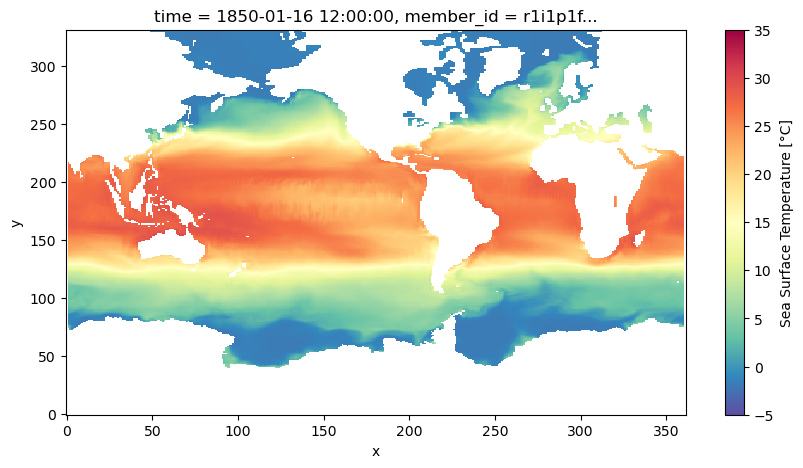

In [17]:
dt['IPSL-CM6A-LR/historical'].isel(member_id=0, dcpp_init_year=0,time=0).tos.plot(cmap='Spectral_r', vmin=-5, vmax=35)

Ahora podemos calcular anomalía de la temperatura superficial media global ponderada por `latitud` para cada uno de los modelos.

In [18]:
# Temperatura media global
def global_mean_sst(ds):
    return ds.tos.weighted(ds.areacello.fillna(0)).mean(['x', 'y']).persist() 

timeseries = dt.map_over_subtree(global_mean_sst)
timeseries

DataTree('None', parent=None)
├── DataTree('CMCC-ESM2')
│   ├── DataTree('ssp126')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 253), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 255), meta=np.ndarray>
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 252), meta=np.ndarray>
│   ├── DataTree('ssp370')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 252), meta=np.ndarray>
│   └── DataTree('ssp585')
│           Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│           Coordinates:
│             * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│             * member_id       (member_id) object 'r1i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 253), meta=np.ndarray>
├── DataTree('EC-Earth3')
│   ├── DataTree('ssp585')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 134), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 134), meta=np.ndarray>
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) f

Podemos generar una serie de tiempo para inspeccionar los resultados. Usemos el modelo IPSl con el escenario ssp585.

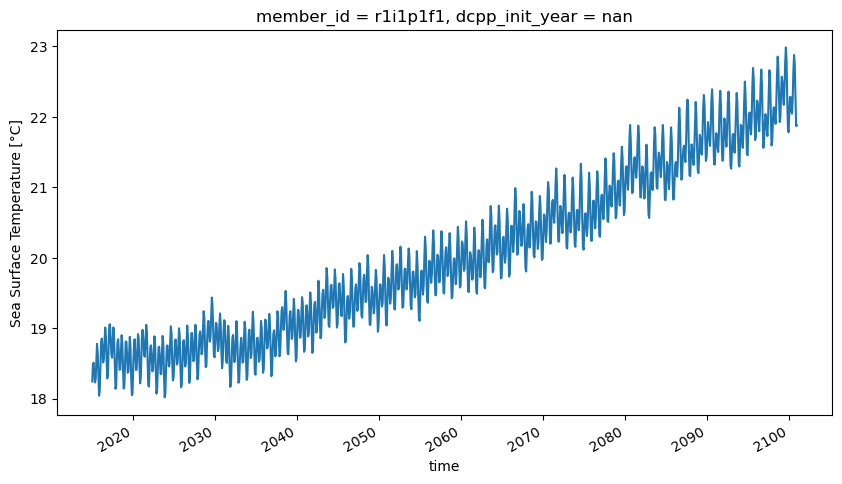

In [19]:
ds_IPSL_ssp585 = timeseries['/IPSL-CM6A-LR/ssp585'].ds
ds_IPSL_ssp585 = ds_IPSL_ssp585.assign_coords(time=('time', ds_IPSL_ssp585.time.data.astype("datetime64[ns]")))
ds_IPSL_ssp585['tos'].plot()

## 2. Anolamía de la temperatura media global ponderada

De igual manera podemos remover el ciclo estacional, también llamado “climatología”, para calcular la anomalia de la temperatura superficial del oceano. 

In [20]:
# Valor medio histórico de referencia
def get_ref_value(ds):
    return ds.sel(time=slice('1950','1980')).mean('time')

anomaly = DataTree()

for model_name, model in timeseries.children.items():
    # model-specific base period
    base_period = get_ref_value(model["historical"].ds)
    anomaly[model_name] = model - base_period   # subtree - Dataset

In [21]:
display(anomaly)

DataTree('None', parent=None)
├── DataTree('CMCC-ESM2')
│   ├── DataTree('ssp126')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 253), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 255), meta=np.ndarray>
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 252), meta=np.ndarray>
│   ├── DataTree('ssp370')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 252), meta=np.ndarray>
│   └── DataTree('ssp585')
│           Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│           Coordinates:
│             * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│             * member_id       (member_id) object 'r1i1p1f1'
│             * dcpp_init_year  (dcpp_init_year) float64 nan
│           Data variables:
│               tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 253), meta=np.ndarray>
├── DataTree('EC-Earth3')
│   ├── DataTree('ssp585')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 134), meta=np.ndarray>
│   ├── DataTree('historical')
│   │       Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) float32 dask.array<chunksize=(1, 1, 134), meta=np.ndarray>
│   ├── DataTree('ssp245')
│   │       Dimensions:         (time: 1032, member_id: 1, dcpp_init_year: 1)
│   │       Coordinates:
│   │         * time            (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
│   │         * member_id       (member_id) object 'r1i1p1f1'
│   │         * dcpp_init_year  (dcpp_init_year) float64 nan
│   │       Data variables:
│   │           tos             (member_id, dcpp_init_year, time) f

Los datos de los modelos de cambio climático traen una estampa de `tiempo` en formato `cftime.DatetimeGregorian`. `Xarray` y `Matplotlib` generalmente trabajan con estampas de tiempo de `datetime64`. Debemos convertir estos índices usando la funcion `replace_time`. Luego podemos agrupar los datos por escenario usando un `diccionario` como se muestra acontinuación

In [22]:
#anomaly['/IPSL-CM6A-LR/ssp585'].time

In [23]:
def replace_time(ds):
    start_date = ds.time.data[0]
    new_time = date_range(f"{start_date.year}-{start_date.month:02}", freq='1MS', periods=len(ds.time))
    ds_new_cal = ds.assign_coords(time=new_time, source_id=model_name)
    return ds_new_cal
    

experiment_dict = {k:[] for k in ['historical','ssp126', 'ssp370', 'ssp245', 'ssp585']}

experiment_dict

{'historical': [], 'ssp126': [], 'ssp370': [], 'ssp245': [], 'ssp585': []}

Iteramos sobre cada uno de los modelos en el objeto `datatree` donde tenemos las anomalias de la temperatura superficial del mar y las agregamos a cada una de las llaves del diccionario

In [24]:
for model_name, model in list(anomaly.children.items()):
    for experiment_name, experiment in model.children.items():
        # replace the time dimension
        ds_new_cal = replace_time(experiment.ds)
        experiment_dict[experiment_name].append(ds_new_cal.load())

Concatenamos cada escenario a lo largo de la dimension `source_id`

In [25]:
# Concatenar todos los modelos para un determinado experimento 
plot_dict = {k:xr.concat(ds_lst, dim='source_id') for k, ds_lst in experiment_dict.items()}
plot_dict

{'historical': <xarray.Dataset>
 Dimensions:         (member_id: 1, dcpp_init_year: 1, source_id: 6, time: 1980)
 Coordinates:
   * member_id       (member_id) object 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) float64 nan
   * time            (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
   * source_id       (source_id) <U13 'CMCC-ESM2' 'EC-Earth3' ... 'CESM2'
 Data variables:
     tos             (source_id, member_id, dcpp_init_year, time) float32 -0.0...,
 'ssp126': <xarray.Dataset>
 Dimensions:         (member_id: 1, dcpp_init_year: 1, source_id: 5, time: 1032)
 Coordinates:
   * member_id       (member_id) object 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) float64 nan
   * time            (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2100-12-01
   * source_id       (source_id) <U13 'CMCC-ESM2' 'EC-Earth3' ... 'IPSL-CM6A-LR'
 Data variables:
     tos             (source_id, member_id, dcpp_init_year, time) float32 0.46...,
 'ssp370': <xarray.Dataset>
 Dime

Comprobamos que nuestras estampas de tiempo esten en el formato `datetime64`

In [26]:
plot_dict['historical'].time

<xarray.DataArray 'time' (time: 1980)>
array(['1850-01-01T00:00:00.000000000', '1850-02-01T00:00:00.000000000',
       '1850-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01

Finalmente generamos nuestra gráfica de las proyecciones de la anomalia de temperatura superficial del mar bajo los distintos escenarios. Para esto podemos usar la función [`shaded_line_plot`](https://xarrayutils.readthedocs.io/en/latest/_modules/xarrayutils/plotting.html#shaded_line_plot) que produce un gráfico de líneas con intervalos sombreados según la extensión del `datarray` en la dimensión `dim`. **Creamos nuestra ensamble multimodelo!!!**

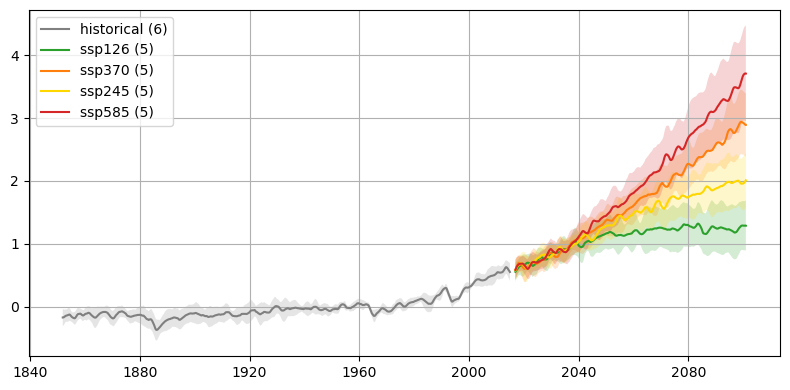

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))

color_dict = {
    'historical':'0.5',
    'ssp126': 'C2',
    'ssp245': 'gold',
    'ssp370': 'C1',
    'ssp585': 'C3',
    'observations': 'C5'
}
for experiment, ds in plot_dict.items():
    color = color_dict[experiment]
    smooth = ds['tos'].sel(time=slice(None, '2100')).isel(member_id=0).rolling(time=2*12).mean().squeeze(['dcpp_init_year'])
    lw = 2 if experiment=='observations' else 1.5
    shaded_line_plot(smooth, 'source_id', ax=ax, spreads=[2.0], alphas=[0.2], 
                     line_kwargs=dict(color=color, 
                                      label=f"{experiment} ({len(ds.source_id)})", 
                                      lw=lw))
plt.legend(loc=2);
plt.grid()
plt.tight_layout()

---

## Resumen final
En este cuadernillo (notebook) revisamos temas relacionados con el acceso a la informacion proveniente de diferentes escenarios de Cambio Climático .....


## Fuentes y referencias
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!